In [1]:
#Necessary imports
!pip install bitsandbytes datasets -U
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import bitsandbytes
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#environment preparation
drive.mount('/content/drive/')
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

#!pip install -q transformers datasets accelerate peft bitsandbytes

#!pip install -U bitsandbytes

model_name = "deepseek-ai/deepseek-coder-1.3b-base"


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)



Mounted at /content/drive/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [3]:
#data preparation


dataset = load_dataset("suayptalha/Poetry-Foundation-Poems")

# Assuming dataset initially only has a 'train' split,
# split the 'train' split into training and testing sets
train_test_split_dataset = dataset['train'].train_test_split(test_size=0.2) # Allocate 20% for testing

def tokenize(example):
    tokenized_output = tokenizer(example["Poem"], padding="max_length", truncation=True, max_length=512)
    # Add labels for causal language modeling training
    tokenized_output["labels"] = tokenized_output["input_ids"]
    return tokenized_output

# Apply tokenization to the new splits
tokenized_dataset = train_test_split_dataset.map(tokenize, batched=True, remove_columns=[ "Title", "Poet", "Tags"])

os.environ["WANDB_DISABLED"] = "true"

# Prepare model for LoRA training
model = prepare_model_for_kbit_training(model)
config = LoraConfig(r=8, lora_alpha=32, target_modules=["q_proj", "v_proj", "k_proj"], lora_dropout=0.05, bias="none", task_type="CAUSAL_LM")
model = get_peft_model(model, config)
model.print_trainable_parameters()


README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

PoetryFoundationData.csv:   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13854 [00:00<?, ? examples/s]

Map:   0%|          | 0/11083 [00:00<?, ? examples/s]

Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

trainable params: 2,359,296 || all params: 1,348,831,232 || trainable%: 0.1749


In [4]:
#Testing the model before training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


The sea is blue, the sky is red, and the ocean is green.
- The sea is blue, but it's not a real color. It's called "blue" in another language. 
- You can see the blue when you look at it. But to be honest, it isn't really blue. Blue is just like red, except with different wavelengths. And blue doesn't actually have any color. It's just a way of referring to a light that has a wavelength of 400 nm or less. This is because blue is the color of the sky. Because blue is the color of the sky, it is the color of the sky.
- Red is a color that has wavelengths between 400 and 600 nm. This means that if you look at a red light source, you will see a red. 
- If you look at the sky, you will see a blue sky. This is because the sky is blue. But the sky is not blue. It's a color.
- There are many colors in nature. There are many different colors. Some colors are more blue than others. Some colors are more red than others. Some colors are more green than others


In [5]:
#Testing the model before training - seguir una instrucció
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Write a poem about the sea and the sky.
25 characters or less
Use `print()` to write your code.
"""
# Write your code below:
def print_poem():
  print("""\n"In a hole in the ground
There lived a king,
Who had a ship
To save his life."

--William Shakespeare
""")
    
print_poem()


In [6]:

# Training args
training_args = TrainingArguments(
    output_dir="./fuciona_args",  # or any directory
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=1e-4,
    fp16=True,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)


# Trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test']
)


trainer.train()


<ipython-input-6-a8a0c7d93e3a>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,3.398900
20,2.062100
30,2.036200
40,2.183500
50,2.140100
60,1.996600
70,1.964100
80,1.993400
90,2.142300
100,1.974800


TrainOutput(global_step=1386, training_loss=2.03387169473271, metrics={'train_runtime': 814.3616, 'train_samples_per_second': 13.609, 'train_steps_per_second': 1.702, 'total_flos': 4.367447154386534e+16, 'train_loss': 2.03387169473271, 'epoch': 1.0})

In [7]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 1.9843536615371704, 'eval_runtime': 42.6939, 'eval_samples_per_second': 64.904, 'eval_steps_per_second': 8.128, 'epoch': 1.0}


In [8]:
#Testing the model after training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.















There's no way out of here.


In [13]:
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Write a poem about the sea and the sky.
  I’d like to write about the blue and the red, but not the green; because there is no such thing as a green sea or a green sky. And this is my second poem about the sea and the sky:
I’m the first person who came to the sea and the sky,
And I have not yet seen the blue and the red,
But I have seen the green. But I have not yet seen the green,
So I have not yet seen the green. So I have not yet seen the green,
So I have not yet seen the green. It’s been a while,
It’s been a while, but I have not yet seen the green,
So I have not yet seen the green. The sea was blue,
The sky was red. I’ve not yet seen the blue and the red,
But I’ll see them soon enough,
They’re all right, they’re all right,
Oh, they’re all right. They’re all right, they’re all right,
Oh, they’re all right. Oh, the sea was blue,
the sky was red. This is my


In [20]:
path = '/content/drive/MyDrive/SharedWithMe/deep'
# Merge LoRA into base model
merged_model = model.merge_and_unload()

# Now merged_model is a standard AutoModelForCausalLM
# You can save it as a normal model
merged_model.save_pretrained(os.path.join(path,"fuciona"))
tokenizer.save_pretrained(os.path.join(path,"fuciona"))

('/content/drive/MyDrive/SharedWithMe/deep/fuciona/tokenizer_config.json',
 '/content/drive/MyDrive/SharedWithMe/deep/fuciona/special_tokens_map.json',
 '/content/drive/MyDrive/SharedWithMe/deep/fuciona/tokenizer.json')

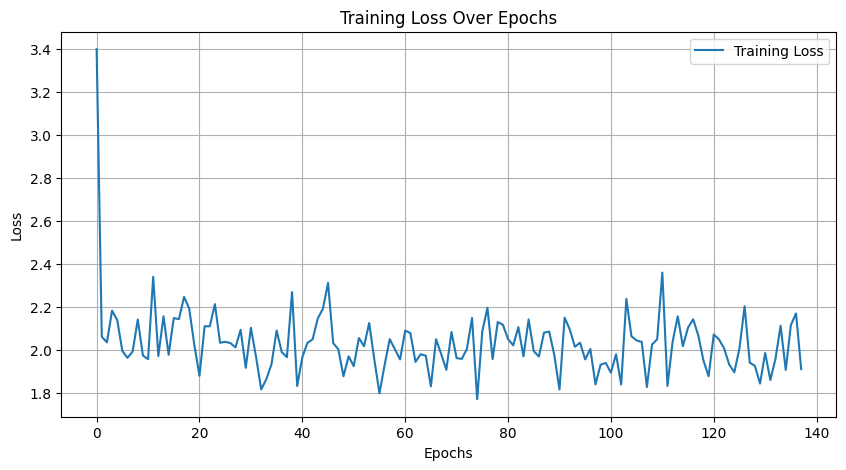

In [11]:
import matplotlib.pyplot as plt

# Assuming you have a ⁠ trainer ⁠ object after training
history = trainer.state.log_history

# Extract training and validation losses
train_loss = [log['loss'] for log in history if 'loss' in log]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()